In [1]:
import math
import numpy as np
import urllib.request
import re
# used to parse values into the url
import urllib.parse
%matplotlib inline
import matplotlib.pyplot as plt
import time
import pandas as pd
from Bio import Entrez
import time
from Bio import SeqIO
from textwrap import wrap
import seaborn as sns
from scipy import stats
from collections import Counter
import time

In [2]:
#Kozak Consensus Scoring System

#0=A, 1=T, 2=G, 3=C, 4=N (Missing)
weights = np.array([
       [0.04210526, 0.        , 0.03157895, 0.05263158, 0.        ],
       [0.04210526, 0.05263158, 0.10526316, 0.0625    , 0.        ],
       [0.03157895, 0.04210526, 0.05263158, 0.07368421, 0.        ],
       [0.03157895, 0.01052632, 0.04210526, 0.05263158, 0.        ],
       [0.08421053, 0.07368421, 0.18947368, 0.10526316, 0.        ],
       [0.04210526, 0.05263158, 0.05263158, 0.08421053, 0.        ],
       [0.12631579, 0.0625    , 0.12631579, 0.21052632, 0.        ],
       [0.83157895, 0.12631579, 0.65263158, 0.16842105, 0.        ],
       [0.15789474, 0.06315789, 0.11578947, 0.2       , 0.        ],
       [0.21052632, 0.09473684, 0.31578947, 0.51578947, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.24210526, 0.16666667, 0.53684211, 0.13684211, 0.        ],
       [0.15789474, 0.09473684, 0.09473684, 0.24210526, 0.        ],
       [0.05263158, 0.08421053, 0.14736842, 0.09473684, 0.        ],
       [0.07216495, 0.05263158, 0.10526316, 0.06315789, 0.        ],
       [0.        , 0.        , 0.        , 0.05263158, 0.        ],
       [0.05263158, 0.05263158, 0.10526316, 0.09473684, 0.        ],
       [0.04210526, 0.03157895, 0.05263158, 0.04210526, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.04210526, 0.04210526, 0.08421053, 0.07368421, 0.        ],
       [0.0625    , 0.04210526, 0.09473684, 0.05263158, 0.        ]
])

#Below function scores using consensus kozak motif scores
def similarity_score(sequence):
                
    #We need consistency and flexibility:
    sequence = sequence.upper().replace('U','T')
    
    holder=''
    
    for i in sequence:
        if i in 'ACTG':
            holder+=i
            
    sequence=holder
    

    
    numbers=[0]*len(sequence)
    
    for k in np.arange(len(sequence)):
        if sequence[k]=='A':
            numbers[k] = 0
        elif sequence[k]=='T':
            numbers[k] = 1
        elif sequence[k]=='G':
            numbers[k] = 2
        elif sequence[k]=='C':
            numbers[k] = 3
        else:
            numbers[k]=4
                
    
    score = 0
    for k in np.arange(len(numbers)):
        score += weights[k][numbers[k]]
            
    max_score = np.sum(weights.max(axis=1))
    
    score = score/max_score
    
    #Final scoring value: we take the maximum possible score 
    #calculated, and return our score divided by the maximum (to normalize from range 0 to 1) 
    
    return(score)

In [3]:
noncanonical=pd.read_excel('Alternative TICs in Genes Associated with Cancer.xlsx')
noncanonical['Codon']=[i[11:14] for i in noncanonical['Translation Initiation Codon (TIC) with Flanking Sequence']]
noncanonical=noncanonical[noncanonical['Codon'].isin(['CTG','GTG','TTG','ACG','AGG','AAG','ATC','ATA','ATT'])]
counts=Counter(noncanonical['Codon'])

In [4]:
import numpy
def absolute_value(val):
    a  = int(numpy.round(val/100.*np.array(list(counts.values())).sum(), 0))
    return a

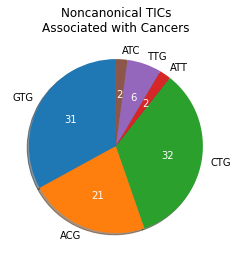

In [25]:
font = {'fontname':'Arial'}  
plt.rc('font',family='Arial')
plt.title("\n".join(wrap( "Noncanonical TICs Associated with Cancers", 25)))
_, _, autotexts=plt.pie([float(v) for v in counts.values()], labels=[k for k in counts],
               autopct=absolute_value,
        shadow=True, startangle=90)

for autotext in autotexts:
    autotext.set_color('white')
    
#plt.savefig('Fig1.svg')    

In [6]:
Entrez.email ="email.here@email.com"

results=[]    

for nu_id in noncanonical['Nucleotide ID of Transcript']:
    try:
        request=Entrez.epost('nucleotide',id=nu_id)    
        result = Entrez.read(request)
        webEnv = result["WebEnv"]
        queryKey = result["QueryKey"]
        handle = Entrez.efetch(db="nucleotide",retmode="xml", webenv=webEnv, query_key=queryKey)
        for index,r in enumerate(Entrez.parse(handle)):
            try:
                CDS_start= int(re.search(r"'GBFeature_key\': \'CDS\', \'GBFeature_location\': \'(.*?)\', \'GBFeature_intervals\': ",str(r)).group(1).split('..')[0])-1
                seq=r['GBSeq_sequence'].upper()
                gene = re.search(r"{'GBQualifier_name': 'gene', 'GBQualifier_value': '(.*?)'}, {'GBQualifier_name': 'gene_synonym', 'GBQualifier_value': '", str(r)).group(1)
                if len(gene)>20:
                    gene='HSPB1'
                gene_synonyms = re.search(r"{\'GBQualifier_name\': \'gene_synonym\', \'GBQualifier_value\': \'(.*?)'}, {'GBQualifier_name", str(r)).group(1)
                results+=[[gene,CDS_start,seq,nu_id]]

            except:
                try:
                    gene = re.search(r"{'GBQualifier_name': 'gene', 'GBQualifier_value': '(.*?)'}, {'GBQualifier_name': '", str(r)).group(1)
                    if len(gene)>20:
                        gene='HSPB1'
                    seq=r['GBSeq_sequence'].upper()
                    CDS_start= int(re.search(r"{'GBFeature_key': 'CDS', 'GBFeature_location': '(.*?)', 'GBFeature_intervals': ",str(r)).group(1).split('..')[0])-1
                    results+=[[gene,CDS_start,seq,nu_id]]

                except:
                    print(nu_id)
            
    except:
        print(nu_id)
    
    time.sleep(0.15)

In [7]:
unique_gene_results=[]
genes=[]
for i in results:
    if i[0] not in genes:
        genes+=[i[0]]
        unique_gene_results+=[i]

In [8]:
KSSs_noncanonical=noncanonical['Kozak Similarity Score (KSS)']
print(np.median(KSSs_noncanonical))

0.794190136938405


In [9]:
KSSs_canonical= [similarity_score(i[2][i[1]-10:i[1]+13]) for i in unique_gene_results]

In [10]:
print(np.median(KSSs_canonical))

0.745720193819695


In [11]:
import pickle

with open("KSSs_randoms", "rb") as fp:   # Unpickling
    KSSs_randoms = pickle.load(fp)


with open("KSS_randoms_from_gene", "rb") as fp:   # Unpickling
    KSS_randoms_from_gene = pickle.load(fp)


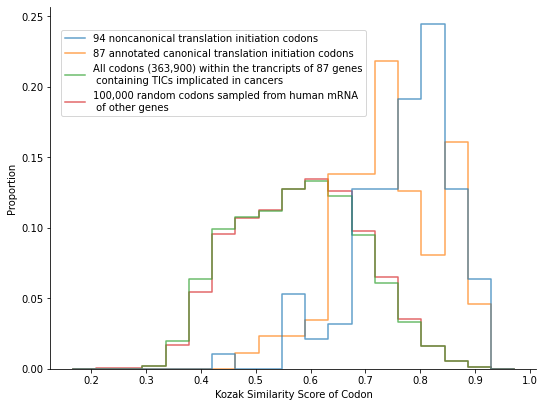

In [12]:
font = {'fontname':'Arial'}  
plt.rc('font',family='Arial')
fig, ax1 = plt.subplots()
sp1 = sns.histplot({'94 noncanonical translation initiation codons':KSSs_noncanonical,\
                    "87 annotated canonical translation initiation codons":KSSs_canonical,
                    "All codons (363,900) within the trancripts of 87 genes\n containing TICs implicated in cancers":KSSs_randoms,\
                    '100,000 random codons sampled from human mRNA\n of other genes':KSS_randoms_from_gene[0:100000]},\
                   stat='proportion', common_norm=False, bins=19, element='step', fill=False, \
                   alpha=0.7,log_scale=False)

ax1.set_xlabel("Kozak Similarity Score of Codon")
fig = plt.gcf()
fig.set_size_inches([i*1.2 for i in plt.rcParamsDefault["figure.figsize"]])
sns.move_legend(ax1, "upper right", bbox_to_anchor=(0.66, 0.95))

title = sns.despine()

fig.tight_layout()

#plt.savefig('Fig2.svg')

In [13]:
gene_kss_dict_unabridged= dict()

for gene,kss in zip(noncanonical['Gene '],noncanonical['Kozak Similarity Score (KSS)']):
    try:
        gene_kss_dict_unabridged[gene]+=[kss]
    except:
        gene_kss_dict_unabridged[gene]=[kss]

In [14]:
def find_possible_codons(seq):
    
    sites=[m.start() for m in re.finditer('CTG',seq)]+[m.start() for m in re.finditer('GTG',seq)]+\
[m.start() for m in re.finditer('TTG',seq)]+[m.start() for m in re.finditer('ACG',seq)]+\
[m.start() for m in re.finditer('AGG',seq)]+[m.start() for m in re.finditer('AAG',seq)]+\
[m.start() for m in re.finditer('ATC',seq)]+[m.start() for m in re.finditer('ATA',seq)]+\
[m.start() for m in re.finditer('ATC',seq)]+[m.start() for m in re.finditer('ATG',seq)]

    return(sites)

In [15]:
def compute_rank_unabridged(gene):
    try:
        
        ranks=[]
        
        for compare_to in gene_kss_dict_unabridged[gene[0]]:
            sequence = gene[2]
            scores = []
            positions = find_possible_codons(sequence[0:gene[1]])
            
            for i in positions:
                upstream=sequence[i-10:i+3]
                
                if len(upstream)<13:
                    upstream=sequence[0:i+3]
                    
                    while len(upstream)<13:
                        upstream='N'+upstream
                
                downstream=sequence[i+3:i+13]
                
                if len(downstream)<10:
                    downstream+='N'
                    
                scores+=[similarity_score(upstream+downstream)]
            
            rank=1
            
            for score in scores:
                if compare_to<score:
                    rank+=1
                    
            ranks+=[rank]
            
        return([gene[0],sequence[0:gene[1]],ranks,len(positions)])
    except:
        print(gene[0])
    
    
#[0, 5, 10, 15]

In [16]:
near_cog_ranks_sets=[]
near_cog_num_candidates=[]
for i in unique_gene_results:
        result=compute_rank_unabridged(i)
        near_cog_ranks_sets+=[result[2]]
        near_cog_num_candidates+=[result[3]]

    
near_cog_ranks=[]
for i in near_cog_ranks_sets:
    for x in i:
        near_cog_ranks+=[x]   

In [17]:
stats.mode(near_cog_ranks)

ModeResult(mode=array([1]), count=array([22]))

In [18]:
(sum(np.array(near_cog_ranks)==1)+sum(np.array(near_cog_ranks)==2)+(sum(np.array(near_cog_ranks)==3)))/len(near_cog_ranks)

0.5531914893617021

In [19]:
np.mean(near_cog_num_candidates)

31.06896551724138

In [20]:
np.median(near_cog_ranks)

3.0

In [21]:
def compute_rank(gene):
    sequence = gene[2]
    compare_to=similarity_score(gene[2][gene[1]-10:gene[1]+13])
    scores = []
    atg_pos = [m.start() for m in re.finditer('ATG',sequence)]
    
    for i in atg_pos:
        upstream=sequence[i-10:i+3]
        
        if len(upstream)<13:
            upstream=sequence[0:i+3]
            
            while len(upstream)<13:
                upstream='N'+upstream
        
        downstream=sequence[i+3:i+13]
        
        if len(downstream)<10:
            downstream+='N'
            
        scores+=[similarity_score(upstream+downstream)]
    
    rank=1
    
    for score in scores:
        if compare_to<score:
            rank+=1
    
    return(rank,len(atg_pos)+1)

In [22]:
canonical_ranks=[]
ATGs_per = []

for canonical in unique_gene_results:
    result=compute_rank(canonical)
    canonical_ranks+=[result[0]]
    ATGs_per+=[result[1]]

In [24]:
stats.mode(canonical_ranks)

ModeResult(mode=array([1]), count=array([24]))

In [26]:
np.median(canonical_ranks)

5.0

In [28]:
(sum(np.array(canonical_ranks)==1)+sum(np.array(canonical_ranks)==2)+sum(np.array(canonical_ranks)==3)+sum(np.array(canonical_ranks)==4)+sum(np.array(canonical_ranks)==5))/len(canonical_ranks)

0.5402298850574713

In [30]:
print(np.mean(ATGs_per))

74.96551724137932


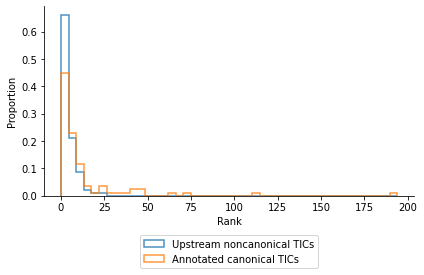

In [31]:
#import seaborn as sns
#plt.style.use('seaborn-colorblind')
font = {'fontname':'Arial'}  
plt.rc('font',family='Arial')
fig= plt.figure()
ax= fig.add_subplot(111)

ax.hist(near_cog_ranks,bins = np.linspace(0,max(canonical_ranks),45),histtype=u'step',alpha=0.8,
           weights=np.ones(len(near_cog_ranks)) / len(near_cog_ranks),
          label = "Upstream noncanonical TICs",linewidth=1.5)

ax.hist(canonical_ranks,bins = np.linspace(0,max(canonical_ranks),45),histtype=u'step',alpha=0.8,
           weights=np.ones(len(canonical_ranks)) / len(canonical_ranks),
          label = "Annotated canonical TICs",linewidth=1.5)

#title = ax.set_title("\n".join(wrap('Proportion of TICs by Kozak Similarity Score Rank', 1000)))
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,-0.18))
plt.xlabel("Rank")
plt.ylabel("Proportion")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()
#plt.savefig('Fig3.svg')
plt.show()

In [32]:
KSSs_noncanonical_sorted = list(KSSs_noncanonical).copy()
KSSs_noncanonical_sorted.sort()
print(stats.mannwhitneyu(KSSs_canonical,KSSs_noncanonical_sorted,alternative='less'))
print(stats.mannwhitneyu(KSSs_canonical,KSSs_noncanonical_sorted[1:len(KSSs_noncanonical_sorted)],alternative='less'))

MannwhitneyuResult(statistic=3412.5, pvalue=0.027463165581749896)
MannwhitneyuResult(statistic=3325.5, pvalue=0.019718665748882466)
